ViGNN Training

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch_geometric.data import DataLoader, Data
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import (
    accuracy_score, 
    precision_recall_fscore_support, 
    confusion_matrix, 
    roc_auc_score
)
from tqdm import tqdm
import numpy as np
from PIL import Image
import torchvision.transforms as transforms

In [2]:
def load_and_preprocess_image(image_path, augment=False):
    """
    Load and preprocess the image.
    
    Args:
        image_path (str): Path to the image file.
        augment (bool): Whether to apply data augmentation.
    
    Returns:
        torch.Tensor: Transformed image tensor.
    """
    image = Image.open(image_path).convert('RGB')
    
    # Basic transformations
    transform_list = [
        transforms.Resize((224, 224)),  # Resize to standard size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
    
    # Add augmentation if requested
    if augment:
        transform_list = [
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
        ] + transform_list
    
    transform = transforms.Compose(transform_list)
    return transform(image)

In [3]:
def create_image_patches(img_tensor, patch_size):
    """
    Create patches from the image tensor.
    
    Args:
        img_tensor (torch.Tensor): Image tensor of shape [C, H, W].
        patch_size (int): Size of each square patch.
    
    Returns:
        torch.Tensor: Patches tensor of shape [num_patches, C, patch_size, patch_size].
    """
    C, H, W = img_tensor.size()
    patches = img_tensor.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
    patches = patches.reshape(C, -1, patch_size, patch_size).permute(1, 0, 2, 3)
    return patches

In [4]:
def flatten_patches(patches):
    """
    Flatten patches to create node features.
    
    Args:
        patches (torch.Tensor): Patches tensor of shape [num_patches, C, patch_size, patch_size].
    
    Returns:
        torch.Tensor: Flattened patches tensor of shape [num_patches, C*patch_size*patch_size].
    """
    return patches.reshape(patches.size(0), -1)

In [5]:
def create_edge_index(num_patches, patches_per_row):
    """
    Create edge indices connecting adjacent patches.
    
    Args:
        num_patches (int): Total number of patches.
        patches_per_row (int): Number of patches per row.
    
    Returns:
        torch.Tensor: Edge indices tensor of shape [2, num_edges].
    """
    edge_index = []
    for i in range(num_patches):
        row, col = i // patches_per_row, i % patches_per_row
        
        # Connect to right neighbor
        if col < patches_per_row - 1:
            edge_index.extend([[i, i + 1], [i + 1, i]])
        
        # Connect to bottom neighbor
        if row < (num_patches // patches_per_row) - 1:
            bottom_idx = i + patches_per_row
            edge_index.extend([[i, bottom_idx], [bottom_idx, i]])
    
    return torch.tensor(edge_index, dtype=torch.long).t()

In [6]:
def image_to_graph(image_path, patch_size=16, augment=False):
    """
    Convert an image to a graph representation where each node represents an image patch.
    
    Args:
        image_path (str): Path to the image file.
        patch_size (int): Size of each square patch.
        augment (bool): Whether to apply data augmentation.
    
    Returns:
        Data: PyTorch Geometric Data object containing the graph representation.
    """
    # Load and preprocess image
    img_tensor = load_and_preprocess_image(image_path, augment)
    
    # Create patches
    patches = create_image_patches(img_tensor, patch_size)
    
    # Flatten patches for node features
    x = flatten_patches(patches)
    
    # Calculate edge indices
    num_patches = patches.size(0)
    patches_per_row = img_tensor.size(1) // patch_size
    edge_index = create_edge_index(num_patches, patches_per_row)
    
    # Create PyG Data object
    return Data(x=x, edge_index=edge_index)

In [7]:
class DatasetLoader:
    def __init__(self, dataset, batch_size, augmentations=None):
        self.dataset = dataset
        self.batch_size = batch_size
        self.augmentations = augmentations

    def load_data(self, few_shot=False, n_samples_per_class=None):
        if few_shot:
            return self._few_shot_sample(n_samples_per_class)
        return DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True)

    def _few_shot_sample(self, n_samples_per_class):
        sampled_data = []
        class_counts = {}
        for data in self.dataset:
            label = data.y.item()
            if label not in class_counts:
                class_counts[label] = 0
            if class_counts[label] < n_samples_per_class:
                sampled_data.append(data)
                class_counts[label] += 1
        return DataLoader(sampled_data, batch_size=self.batch_size, shuffle=True)

In [8]:
class ViGModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=2):
        super(ViGModel, self).__init__()
        self.input_dim = input_dim
        self.conv1 = nn.Conv1d(input_dim, hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        # self.dropout = nn.Dropout(0.3)
        self.dropout = nn.Dropout(p=0.5)

        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        batch_size = data.batch.max().item() + 1

        # Reshape x to [batch_size, input_dim, num_nodes]
        num_nodes = x.size(0) // batch_size
        x = x.view(batch_size, num_nodes, -1)  # [batch_size, num_nodes, features]
        x = x.transpose(1, 2)  # [batch_size, features, num_nodes]

        # Apply convolutions
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))

        # Global pooling
        x = x.mean(dim=2)  # [batch_size, hidden_dim]

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x    

In [9]:
class FewShotTrainer:
    def __init__(self, model, optimizer, criterion, device):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device

    def train(self, dataloader, epochs):
        self.model.train()
        for epoch in range(epochs):
            total_loss = 0
            for data in dataloader:
                data = data.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(data)
                loss = self.criterion(outputs, data.y)
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader)}")

In [10]:
class Evaluator:
    def __init__(self):
        pass

    def compute_metrics(self, y_true, y_pred, y_probs):
        acc = accuracy_score(y_true, y_pred)
        prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
        auc = roc_auc_score(y_true, y_probs)
        conf_matrix = confusion_matrix(y_true, y_pred)
        return {
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1_score": f1,
            "auc": auc,
            "confusion_matrix": conf_matrix
        }

In [11]:
#def save_vig_model(model, path):
#    torch.save(model.state_dict(), path)

In [12]:
def visualize_training_results(metrics):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(metrics['epochs'], metrics['train_loss'], label='Train Loss')
    plt.plot(metrics['epochs'], metrics['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(metrics['epochs'], metrics['train_acc'], label='Train Accuracy')
    plt.plot(metrics['epochs'], metrics['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [13]:
def load_graph_dataset(data_dir, patch_size=16, augment_train=True):
    """
    Load dataset from structured directory.
    Expected structure:
    data_dir/
        train/
            fake/
                image1.jpg
                ...
            real/
                image1.jpg
                ...
        validation/
            fake/
                image1.jpg
                ...
            real/
                image1.jpg
                ...
        test/
            fake/
                image1.jpg
                ...
            real/
                image1.jpg
                ...
    """
    splits = ['train', 'validation']   #splits = ['train', 'validation', 'test'] if we want to include test
    folder_labels = {"fake": 0, "real": 1}
    datasets = {}
    
    print(f"\nLoading dataset from {data_dir}")
    if not os.path.exists(data_dir):
        raise ValueError(f"Data directory not found: {data_dir}")

    for split in splits:
        split_dir = os.path.join(data_dir, split)
        if not os.path.exists(split_dir):
            raise ValueError(f"Split directory not found: {split_dir}")
        
        print(f"\nProcessing {split} split...")
        data_list = []
        
        for folder_name, label in folder_labels.items():
            folder_path = os.path.join(split_dir, folder_name)
            print(f"Checking folder: {folder_path}")
            
            if not os.path.exists(folder_path):
                raise ValueError(f"Required folder not found: {folder_path}")
                
            files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) 
                    if f.lower().endswith(('jpg', 'jpeg', 'png'))]
            
            if not files:
                raise ValueError(f"No image files found in {folder_path}")
                
            print(f"Found {len(files)} images in {folder_path}")
            
            for file_path in tqdm(files, desc=f"Processing {split}/{folder_name}"):
                try:
                    graph = image_to_graph(file_path, patch_size=patch_size, augment=(split == 'train'))
                    graph.y = torch.tensor([label], dtype=torch.long)
                    data_list.append(graph)
                except Exception as e:
                    print(f"Error processing {file_path}: {str(e)}")
        
        if not data_list:
            raise ValueError(f"No valid data was loaded for {split} split.")
            
        print(f"Total graphs created for {split}: {len(data_list)}")
        datasets[split] = data_list
    
    return datasets


In [14]:
def train_vig(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, data.y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == data.y).sum().item()
        total += data.y.size(0)
    
    accuracy = correct / total
    return total_loss / len(train_loader), accuracy

In [15]:
def validate_vig(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            outputs = model(data)
            loss = criterion(outputs, data.y)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == data.y).sum().item()
            total += data.y.size(0)
    
    accuracy = correct / total
    return total_loss / len(loader), accuracy

In [16]:
def configure_training():
    """Set up configuration parameters and return them."""
    data_dir = "/mnt/documents/Minor-Project/Datasets/FF++Snaps"
    patch_size = 16
    hidden_dim = 64
    output_dim = 2
    batch_size = 8
    num_epochs = 20
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    input_dim = 3 * patch_size * patch_size  # RGB channels * patch dimensions

    return data_dir, patch_size, input_dim, hidden_dim, output_dim, batch_size, num_epochs, device

In [17]:
def prepare_data(data_dir, patch_size, batch_size):
    """Load dataset and create data loaders."""
    datasets = load_graph_dataset(data_dir)

    train_loader = DataLoader(datasets['train'], batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(datasets['validation'], batch_size=batch_size, shuffle=False)

    print("\nDataset sizes:")
    print(f"Training samples: {len(datasets['train'])}")
    print(f"Validation samples: {len(datasets['validation'])}")

    return train_loader, val_loader

In [18]:
def initialize_model(input_dim, hidden_dim, output_dim, device):
    """Initialize the model, optimizer, scheduler, and loss function."""
    model = ViGModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim).to(device)
    # optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3)
    criterion = nn.CrossEntropyLoss()

    return model, optimizer, scheduler, criterion

In [19]:
def train_and_evaluate(model, train_loader, val_loader, optimizer, scheduler, criterion, num_epochs, device):
    """Train and validate the model, and return metrics."""
    metrics = {
        'epochs': list(range(1, num_epochs + 1)),
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        # Train
        train_loss, train_accuracy = train_vig(model, train_loader, optimizer, criterion, device)
        
        # Validate
        val_loss, val_accuracy = validate_vig(model, val_loader, criterion, device)

        # Update metrics
        metrics['train_loss'].append(train_loss)
        metrics['val_loss'].append(val_loss)
        metrics['train_acc'].append(train_accuracy)
        metrics['val_acc'].append(val_accuracy)

        # Update learning rate
        scheduler.step(val_loss)

        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    return metrics


Loading and preprocessing dataset...

Loading dataset from /mnt/documents/Minor-Project/Datasets/FF++Snaps

Processing train split...
Checking folder: /mnt/documents/Minor-Project/Datasets/FF++Snaps/train/fake
Found 4200 images in /mnt/documents/Minor-Project/Datasets/FF++Snaps/train/fake


Processing train/fake:   0%|          | 0/4200 [00:00<?, ?it/s]

Processing train/fake: 100%|██████████| 4200/4200 [02:52<00:00, 24.31it/s]


Checking folder: /mnt/documents/Minor-Project/Datasets/FF++Snaps/train/real
Found 4200 images in /mnt/documents/Minor-Project/Datasets/FF++Snaps/train/real


Processing train/real: 100%|██████████| 4200/4200 [02:56<00:00, 23.79it/s]


Total graphs created for train: 8400

Processing validation split...
Checking folder: /mnt/documents/Minor-Project/Datasets/FF++Snaps/validation/fake
Found 900 images in /mnt/documents/Minor-Project/Datasets/FF++Snaps/validation/fake


Processing validation/fake: 100%|██████████| 900/900 [00:31<00:00, 28.85it/s]


Checking folder: /mnt/documents/Minor-Project/Datasets/FF++Snaps/validation/real
Found 900 images in /mnt/documents/Minor-Project/Datasets/FF++Snaps/validation/real


Processing validation/real: 100%|██████████| 900/900 [00:32<00:00, 28.08it/s]
/mnt/documents/Minor-Project/Codes/myenv/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Total graphs created for validation: 1800

Dataset sizes:
Training samples: 8400
Validation samples: 1800

Starting training...

Epoch 1/20
Train Loss: 0.6415, Train Acc: 0.6145
Val Loss: 0.6115, Val Acc: 0.6650

Epoch 2/20
Train Loss: 0.5629, Train Acc: 0.7057
Val Loss: 0.5020, Val Acc: 0.7500

Epoch 3/20
Train Loss: 0.4804, Train Acc: 0.7752
Val Loss: 0.4923, Val Acc: 0.7306

Epoch 4/20
Train Loss: 0.3996, Train Acc: 0.8226
Val Loss: 0.5010, Val Acc: 0.8422

Epoch 5/20
Train Loss: 0.3487, Train Acc: 0.8533
Val Loss: 0.5855, Val Acc: 0.7822

Epoch 6/20
Train Loss: 0.3174, Train Acc: 0.8658
Val Loss: 0.6761, Val Acc: 0.8067

Epoch 7/20
Train Loss: 0.2947, Train Acc: 0.8811
Val Loss: 0.3974, Val Acc: 0.8306

Epoch 8/20
Train Loss: 0.2750, Train Acc: 0.8904
Val Loss: 0.5539, Val Acc: 0.8122

Epoch 9/20
Train Loss: 0.2614, Train Acc: 0.8976
Val Loss: 0.4220, Val Acc: 0.8289

Epoch 10/20
Train Loss: 0.2498, Train Acc: 0.9043
Val Loss: 0.4569, Val Acc: 0.8167

Epoch 11/20
Train Loss: 0.2340

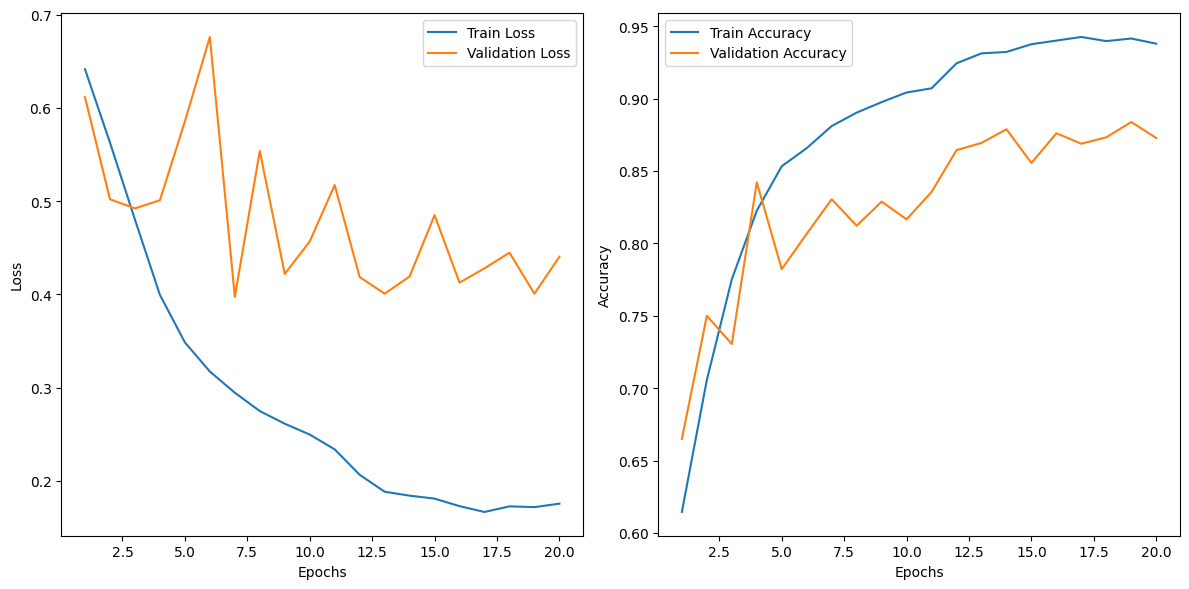

In [20]:

def main():
    # Configuration
    data_dir, patch_size, input_dim, hidden_dim, output_dim, batch_size, num_epochs, device = configure_training()

    # Load and preprocess dataset
    print("\nLoading and preprocessing dataset...")
    train_loader, val_loader = prepare_data(data_dir, patch_size, batch_size)

    # Initialize model, optimizer, scheduler, and loss function
    model, optimizer, scheduler, criterion = initialize_model(input_dim, hidden_dim, output_dim, device)

    # Train and evaluate
    print("\nStarting training...")
    metrics = train_and_evaluate(model, train_loader, val_loader, optimizer, scheduler, criterion, num_epochs, device)

    # Visualize results
    visualize_training_results(metrics)

    ## Test the model
    # print("\nTesting the model...")
    # test_loss, test_accuracy = validate_vig(model, test_loader, criterion, device)
    # print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    ## Save the model
    # save_path = "vig_model.pth"
    # save_vig_model(model, save_path)
    # print(f"\nModel saved to {save_path}")

if __name__ == "__main__":
    main()

In [21]:
torch.save(model, "model.pth")


NameError: name 'model' is not defined

: 